In [1]:
import SDS_Environment as SDS
import pandas as pd
from SDS_Environment import np, plt, tf, Camera, nx

# %matplotlib notebook

# Fanctions

In [2]:
def Initializer(env, N):
    # ---------------------------------------------------------------------------------------
    camera = Camera(plt.figure(figsize=(15,15)))
    
    # ---------------------------------------------------------------------------------------
    # build models
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    input_shape = [3]              # == env.observation_space.shape
    n_outputs = 2                  # == env.action_space.n

    model = []                     # make a model for each agent
    for _ in range(N):
        model.append(tf.keras.models.load_model('100agent.keras', 
                            custom_objects={'custom_activation': tf.keras.layers.Activation(custom_activation)}, 
                            compile=False))
        
    # ---------------------------------------------------------------------------------------
    # initilaze states and rewards from environment class    
    state, reward = env.step(np.zeros(N), 1)
    state = [[state[j][i] for j in range(input_shape[0])] for i in range(N)]
    
    return camera, model, n_outputs, state
    
def custom_activation(x):
    xx = (tf.keras.backend.softplus(x))**0.5
    return -tf.keras.backend.elu(-xx + 100) + 100

In [3]:
def play_one_step(env, model, N, state, episode):
    action = np.zeros(env.N)

    while N < env.N:
        N += 1
        model.append(tf.keras.models.Sequential([
                    tf.keras.layers.Dense(32, activation="elu", input_shape=[len(state[0])]),
                    tf.keras.layers.Dense(32, activation="elu"),
                    tf.keras.layers.Dense(2, activation=custom_activation)
                ]))
                
        model[-1] = tf.keras.models.load_model('100agent.keras', 
                            custom_objects={'custom_activation': tf.keras.layers.Activation(custom_activation)}, 
                            compile=False)

    for i in range(env.N):
        actionnnn = model[i].predict(np.reshape(state[i], (3)).reshape(1, -1), verbose=0)[0]
        action[i] = np.argmax(actionnnn)
    
    next_state, reward = env.step((action-0.5)*2, episode)
    next_state = [[next_state[j][i] for j in range(3)] for i in range(env.N)]

    return next_state

In [4]:
def Plot_Results(episode, Hamilton, Giant, Edges, Tau):
    plt.figure(figsize=(16,12))

    plt.subplot(2,2,1)
    plt.title("Hamilton")
    plt.plot(Hamilton)
    plt.text(0.7*episode, 1.1*max(Hamilton), "Min(H): %f" % (min(Hamilton)) )
    plt.text(0.7*episode, 1.2*max(Hamilton), "Arg(H): %f" % (np.argmin(Hamilton)) )
    plt.grid(alpha=0.3)

    plt.subplot(2,2,2)
    plt.title("Giant Component")
    plt.plot(Giant)
    plt.grid(alpha=0.3)

    plt.subplot(2,2,3)
    plt.title("Transition Range")
    plt.plot(Edges)
    plt.grid(alpha=0.3) 

    plt.subplot(2,2,4)
    plt.title("Tau")
    plt.plot(Tau)
    plt.grid(alpha=0.3) 

    plt.show()

In [5]:
def Calculate_Result(env, P_i, Q_i, previous_):

    # Hamiltonian of the whole system -----------------------------------------
    hamilton = 0
    for i in range(env.N): hamilton += env.Hamiltonian(i)
    # -------------------------------------------------------------------------
    edge  = env.k.sum()/2
    # -------------------------------------------------------------------------
    energy = (0.2*env.r**2).sum()

    # Giant component of network (%) ------------------------------------------
    G = nx.from_numpy_array(env.A)
    giant = len((sorted(nx.connected_components(G), key=len, reverse=True))[0])/env.N * 100

    # Calculate Tau = 1/sM sigma(P_ij/Q_ij) -----------------------------------
    for i in range(env.N):
        for j in range(i, env.N):
            if previous_[i][j] != env.A[i][j]:
                Q_i[i][j] += 1
                Q_i[j][i] += 1

    P_i += env.A
    previous_ = env.A
    tau = 1/(1000* (env.N*(env.N-1)/2)) * (P_i/Q_i).sum()
    
    return hamilton, edge, energy, giant, tau

# Main


Episode: 999, H: -153.685, N: 50.0

 -138.6137669714239


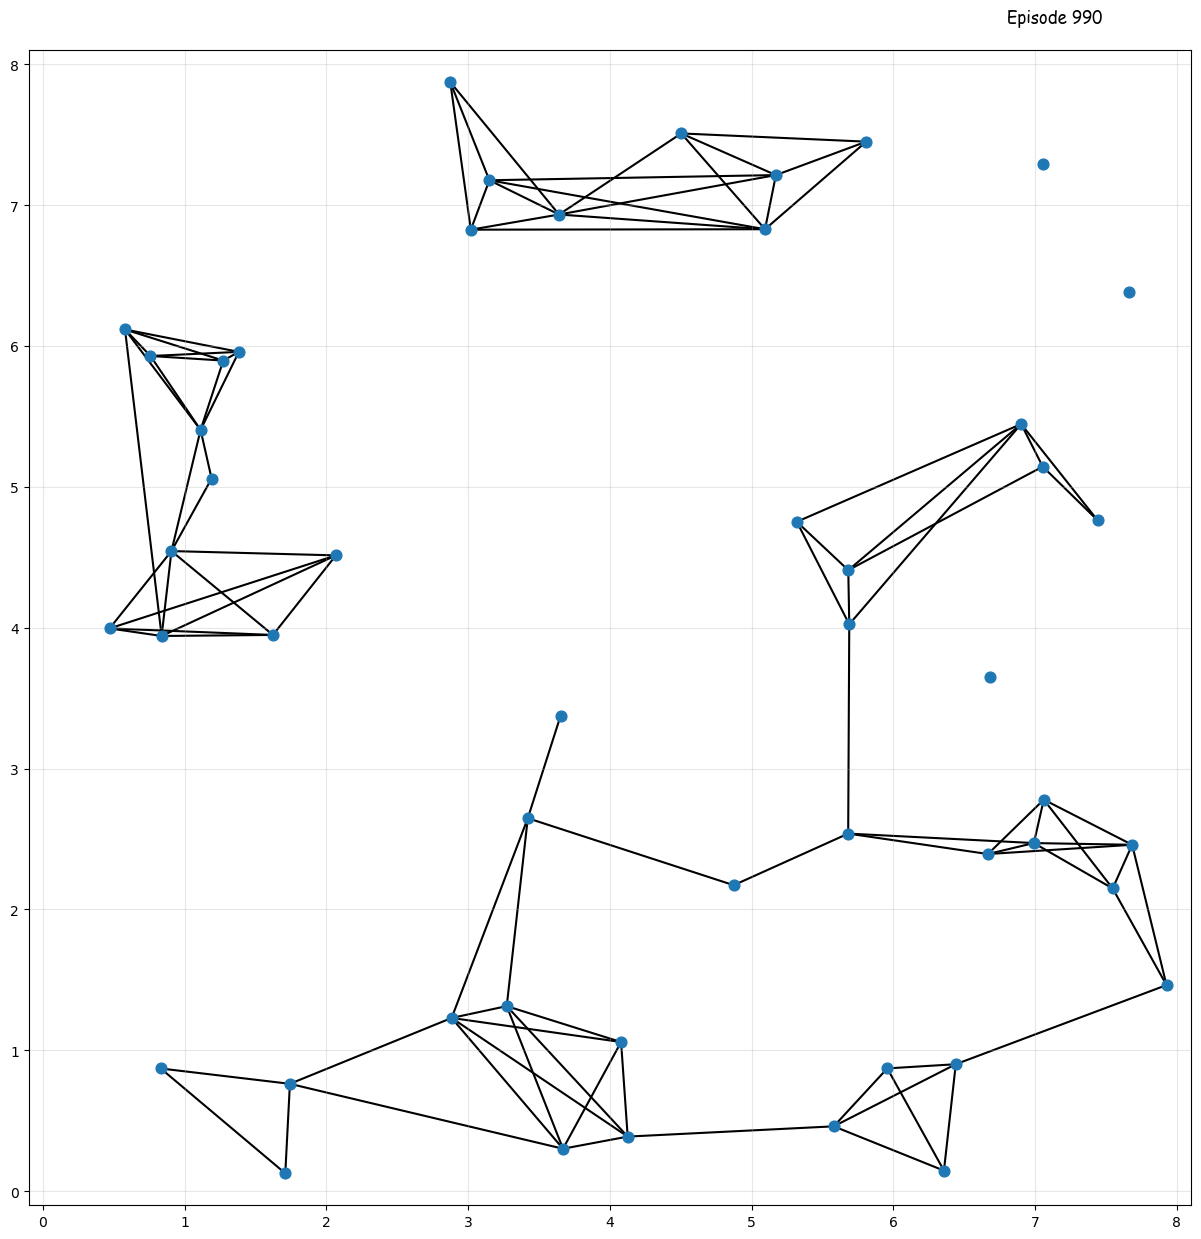

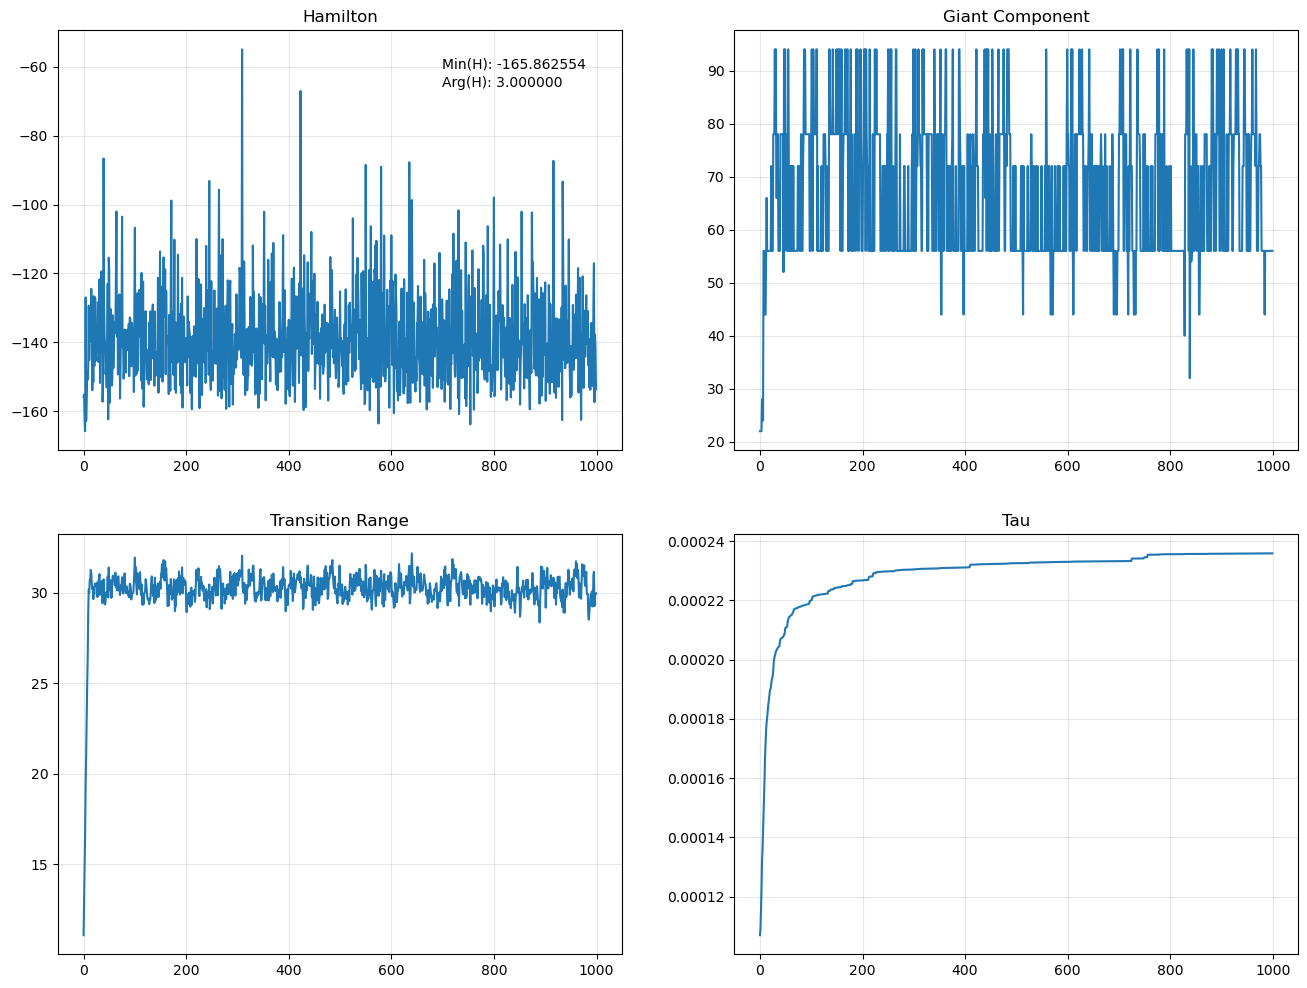

In [6]:
N = 50                      # Number of agents
L = 8                       # The length of the simulation box
env = SDS.Distributed_System(N,L, flipping=True, on_off=False, moving=False)

camera, model, n_outputs, state = Initializer(env, N)
P_ij=np.copy(env.A); Q_ij=np.ones((env.N, env.N)); previous_A=np.zeros((env.N, env.N))

Hamilton = []               # Just for plot total hamilton per episode
Giant  = []                 # Represents the percentage of members of the giant component 
Edges  = []
Energy = []
Tau    = []


for episode in range(1000):
    state = play_one_step(env, model, N, state, episode)
    
    
    # Show Results --------------------------------------------------------------------------
    hamilton, edge, energy, giant, tau = Calculate_Result(env, P_ij, Q_ij, previous_A)
    Hamilton.append(hamilton)
    Edges.append(edge)
    Energy.append(energy)
    Tau.append(tau)
    Giant.append(giant)
    
    if episode%10 == 0: env.Plot(camera, episode)
    
    print("\rEpisode: {}, H: {:.3f}, N: {:.1f}".format(episode, hamilton, env.N), end="")
    
        
anim = camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=True)
anim.save('./All result/animation_.gif')

#-------------------------------------------------------------------------------
print("\n\n", np.average(Hamilton))
Plot_Results(episode, Hamilton, Giant, Energy, Tau)

#-------------------------------------------------------------------------------
df = pd.DataFrame({'Hamilton': Hamilton, 'Giant': Giant, 'Edges': Edges, 'Energy': Energy, 'Tau': Tau})
df.to_csv('./All result/csv/Results_.csv')

# Base Model

In [ ]:
N = 50                      # Number of agents
L = 8                       # The length of the simulation box
env = SDS.Distributed_System(N,L)

camera, model, n_outputs, state = initializer(env, N)

Hamilton = []               # Just for plot total hamilton per episode
Giant  = []                 # Represents the percentage of members of the giant component 
Edges  = []
Energy = []
R_average = []

for episode in range(300):
    action = np.zeros(N)
    for i in range(env.N):
        if env.k[i] < 5:
            action[i] = np.random.randint(2)
    
    next_state, reward = env.step(action, episode)
    next_state = [[next_state[j][i] for j in range(3)] for i in range(env.N)]
    state = next_state
      

    # ---------------------------------------------------------------------------------------
    # Show Results
    H = 0
    for i in range(env.N): H += env.Hamiltonian(i)        # Hamiltonian of the whole system
    Hamilton.append(H) 
    # Edges.append(env.k.sum()/2)
    Energy.append((0.2*env.r**2).sum())
    R_average.append(np.average(env.r))
    
    if episode%1 == 0:
        Giant.append( env.Plot(camera, episode) )

    print("\rEpisode: {}, H: {:.3f}, N: {:.1f}".format(episode, H, env.N), end="")
        
        
anim = camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=True)
anim.save('./All result/animation_C2.gif')

#-------------------------------------------------------------------------------
print("\n", min(Hamilton), np.argmin(Hamilton), R_average[np.argmin(Hamilton)])
Plot_Results(episode, Hamilton, Giant, Energy)

# tests